In [ ]:
!pip install kaggle

In [ ]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow import keras
import os
import cv2
import timeit
import numpy as np
import pandas as pd
from PIL import Image
from tensorflow import keras
import tensorflow as tf
from keras import Model
import matplotlib.pyplot as plt
from keras.metrics import MeanIoU
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD,Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import load_img ,img_to_array
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, classification_report
from tensorflow.keras.layers import MaxPooling2D,BatchNormalization,Conv2D,Dense,Activation,Conv2DTranspose,Input
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D
from tensorflow.keras.layers import Conv2DTranspose, MaxPooling2D, concatenate, AveragePooling2D, Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Flatten,Dropout,SpatialDropout2D,AveragePooling2D,GlobalAveragePooling2D,Concatenate

In [ ]:
import os

# Set the Kaggle API credentials path
os.environ['KAGGLE_CONFIG_DIR'] = "/content"

# Download the dataset
!kaggle datasets download -d aryashah2k/breast-ultrasound-images-dataset

# Unzip the dataset
!unzip -q breast-ultrasound-images-dataset.zip -d breast-ultrasound-images-dataset

 89% 174M/195M [00:01<00:00, 167MB/s]
100% 195M/195M [00:01<00:00, 170MB/s]


In [ ]:
def num (image) :
    val = 0
    for i in range(len(image)) :
        if image[i] == '(' :
            while True :
                i += 1
                if image[i] == ')' :
                    break
                val = (val*10) + int(image[i])
            break
    return val

In [ ]:
X_b, y_b = np.zeros((437, 128, 128, 1)), np.zeros((437, 128, 128, 1))
X_n, y_n = np.zeros((133, 128, 128, 1)), np.zeros((133, 128, 128, 1))
X_m, y_m= np.zeros((210, 128, 128, 1)), np.zeros((210, 128, 128, 1))

In [ ]:
path = "/content/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT"

In [ ]:
import os
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array
from PIL import Image
import re

# Replace 'path' with the path to the dataset directory containing tumor_type subdirectories

# Initialize lists to store the images and their corresponding targets
X_b, X_n, X_m = [], [], []  # Lists to store images
y_b, y_n, y_m = [], [], []  # Lists to store targets

# Regular expression to extract the index from the filename
index_pattern = re.compile(r"\d+")

# Enumerate through tumor_type subdirectories
for tumor_type in os.listdir(path):
    # Enumerate through images in the tumor_type subdirectory
    for image in os.listdir(os.path.join(path, tumor_type)):
        p = os.path.join(path, tumor_type, image)
        img = cv2.imread(p, cv2.IMREAD_GRAYSCALE)  # read image as grayscale
        img = cv2.resize(img, (128, 128))
        pil_img = Image.fromarray(img)


        if image[-5] == ')':
            if image[0] == 'b':
                X_b.append(img_to_array(pil_img))
            elif image[0] == 'n':
                X_n.append(img_to_array(pil_img))
            elif image[0] == 'm':
                X_m.append(img_to_array(pil_img))
        if image[-5] == 'k':
            if image[0] == 'b':
                y_b.append(img_to_array(pil_img))
            elif image[0] == 'n':
                y_n.append(img_to_array(pil_img))
            elif image[0] == 'm':
                y_m.append(img_to_array(pil_img))

# Convert the lists to numpy arrays
X_b = np.array(X_b)
X_n = np.array(X_n)
X_m = np.array(X_m)
y_b = np.array(y_b)
y_n = np.array(y_n)
y_m = np.array(y_m)

In [ ]:
X = np.concatenate((X_b, X_n, X_m), axis = 0)
y = np.concatenate((y_b, y_n, y_m), axis = 0)

In [ ]:
print(X.shape)
print(y.shape)

(780, 128, 128, 1)
(780, 128, 128, 1)


In [ ]:
def convertToOneChannel(img):
    im=np.dot(img[...,:3], [0.2989, 0.5870, 0.1140])
    i=cv2.resize(im, (128, 128))
    return i

In [ ]:
def convertToThreeChannel(img):
    b_np= np.array(img)
    g_np= np.array(img)
    r_np= np.array(img)
    final_img = np.dstack([b_np, g_np, r_np]).astype(np.uint8)
    return np.array(final_img)

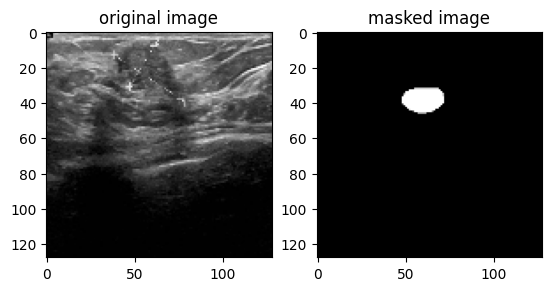

In [ ]:
img=convertToThreeChannel(X[10])
mask=convertToThreeChannel(y[10])
plt.figure
plt.subplot(1,2,1)
plt.imshow(img)
plt.title("original image")
plt.subplot(1,2,2)
plt.imshow(mask)
plt.title("masked image")
plt.show()

In [ ]:
actual=[]
mask=[]
for i in X:
    horizontal_flip = cv2.flip(i, 1)
    vertical_horizontal_flip = cv2.flip(i, -1)
    imagerotate = cv2.rotate(i, cv2.ROTATE_180)
    imagerotate1 = cv2.rotate(i, cv2.ROTATE_90_COUNTERCLOCKWISE)
    imagerotate2 = cv2.rotate(i, cv2.ROTATE_90_CLOCKWISE)
    actual.append(horizontal_flip)
    actual.append(vertical_horizontal_flip)
    actual.append(imagerotate)
    actual.append(imagerotate1)
    actual.append(imagerotate2)

for j in y:
    horizontal_flip_mask = cv2.flip(j, 1)
    vertical_horizontal_flip_mask = cv2.flip(j, -1)
    imagerotate_mask1 = cv2.rotate(j, cv2.ROTATE_90_COUNTERCLOCKWISE)
    imagerotate_mask = cv2.rotate(j, cv2.ROTATE_180)
    imagerotate_mask2 = cv2.rotate(j, cv2.ROTATE_90_CLOCKWISE)
    mask.append(horizontal_flip_mask)
    mask.append(vertical_horizontal_flip_mask)
    mask.append(imagerotate_mask)
    mask.append(imagerotate_mask1)
    mask.append(imagerotate_mask2)

In [ ]:
mask=np.array(mask)
actual=np.array(actual)
print(actual.shape)
print(mask.shape)

(3900, 128, 128)
(3900, 128, 128)


In [ ]:
actual=actual/255
mask=mask/255
print(mask.max())
print(mask.min())

1.0
0.0


In [ ]:
mask[mask > 1.0] = 1.0
print(mask.max())
print(mask.min())

1.0
0.0


In [ ]:
mask=np.array(mask)
actual=np.array(actual)
print(actual.shape)
print(mask.shape)

(3900, 128, 128)
(3900, 128, 128)


In [ ]:
t1=np.full(2185,1)
t2=np.full(665,0)
t3=np.full(1050,2)
T=np.concatenate((t1, t2, t3), axis = 0)
T=np.array(T)
print(T.shape)

(3900,)


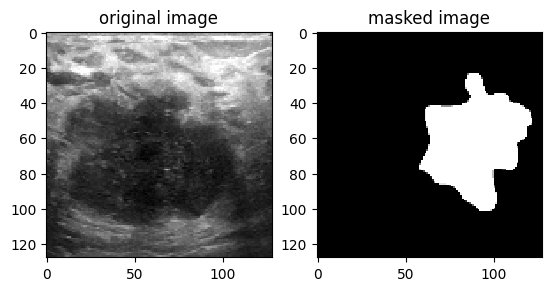

In [ ]:
plt.figure
plt.subplot(1,2,1)
plt.imshow(actual[3000],interpolation='nearest',cmap='gray')
plt.title("original image")
plt.subplot(1,2,2)
plt.imshow(mask[3000],interpolation='nearest',cmap='gray')
plt.title("masked image")
plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(actual, mask, test_size = 0.15, random_state = 1)

In [ ]:
actual1=[]
for i in actual:
    actual1.append(convertToThreeChannel(i) )
mask1=[]
for i in mask:
    mask1.append(convertToThreeChannel(i) )
actual1=np.array(actual1)
mask1=np.array(mask1)

In [ ]:
print(X_train.shape)
print(X_test.shape)

(3315, 128, 128)
(585, 128, 128)


In [ ]:
inply = Input((128, 128, 1,))

conv1 = Conv2D(2**6, (3,3), activation = 'relu', padding = 'same')(inply)
conv1 = Conv2D(2**6, (3,3), activation = 'relu', padding = 'same')(conv1)
pool1 = MaxPooling2D((2,2), strides = 2, padding = 'same')(conv1)
drop1 = Dropout(0.2)(pool1)

conv2 = Conv2D(2**7, (3,3), activation = 'relu', padding = 'same')(drop1)
conv2 = Conv2D(2**7, (3,3), activation = 'relu', padding = 'same')(conv2)
pool2 = MaxPooling2D((2,2), strides = 2, padding = 'same')(conv2)
drop2 = Dropout(0.2)(pool2)

conv3 = Conv2D(2**8, (3,3), activation = 'relu', padding = 'same')(drop2)
conv3 = Conv2D(2**8, (3,3), activation = 'relu', padding = 'same')(conv3)
pool3 = MaxPooling2D((2,2), strides = 2, padding = 'same')(conv3)
drop3 = Dropout(0.2)(pool3)

conv4 = Conv2D(2**9, (3,3), activation = 'relu', padding = 'same')(drop3)
conv4 = Conv2D(2**9, (3,3), activation = 'relu', padding = 'same')(conv4)
pool4 = MaxPooling2D((2,2), strides = 2, padding = 'same')(conv4)
drop4 = Dropout(0.2)(pool4)

In [ ]:
convm = Conv2D(2**10, (3,3), activation = 'relu', padding = 'same')(drop4)
convm = Conv2D(2**10, (3,3), activation = 'relu', padding = 'same')(convm)

In [ ]:
tran5 = Conv2DTranspose(2**9, (2,2), strides = 2, padding = 'valid', activation = 'relu')(convm)
conc5 = Concatenate()([tran5, conv4])
conv5 = Conv2D(2**9, (3,3), activation = 'relu', padding = 'same')(conc5)
conv5 = Conv2D(2**9, (3,3), activation = 'relu', padding = 'same')(conv5)
drop5 = Dropout(0.1)(conv5)

tran6 = Conv2DTranspose(2**8, (2,2), strides = 2, padding = 'valid', activation = 'relu')(drop5)
conc6 = Concatenate()([tran6, conv3])
conv6 = Conv2D(2**8, (3,3), activation = 'relu', padding = 'same')(conc6)
conv6 = Conv2D(2**8, (3,3), activation = 'relu', padding = 'same')(conv6)
drop6 = Dropout(0.1)(conv6)

tran7 = Conv2DTranspose(2**7, (2,2), strides = 2, padding = 'valid', activation = 'relu')(drop6)
conc7 = Concatenate()([tran7, conv2])
conv7 = Conv2D(2**7, (3,3), activation = 'relu', padding = 'same')(conc7)
conv7 = Conv2D(2**7, (3,3), activation = 'relu', padding = 'same')(conv7)
drop7 = Dropout(0.1)(conv7)

tran8 = Conv2DTranspose(2**6, (2,2), strides = 2, padding = 'valid', activation = 'relu')(drop7)
conc8 = Concatenate()([tran8, conv1])
conv8 = Conv2D(2**6, (3,3), activation = 'relu', padding = 'same')(conc8)
conv8 = Conv2D(2**6, (3,3), activation = 'relu', padding = 'same')(conv8)
drop8 = Dropout(0.1)(conv8)

In [ ]:
outly = Conv2D(2**0, (1,1), activation = 'relu', padding = 'same')(drop8)
model = Model(inputs = inply, outputs = outly, name = 'U-net')

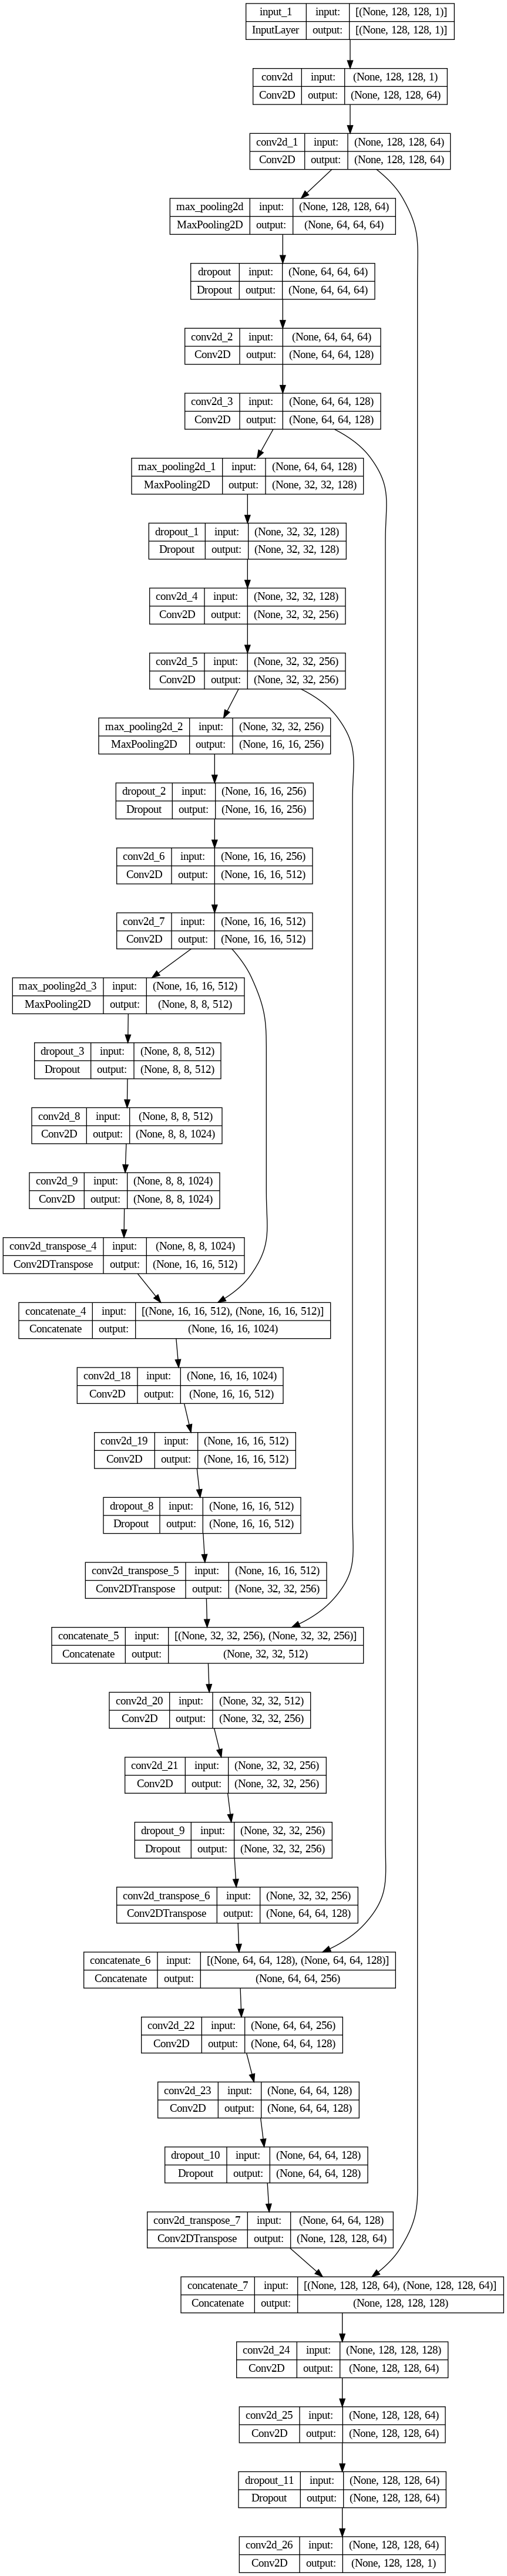

In [ ]:
keras.utils.plot_model(model, './model_plot.png', show_shapes = True)

In [ ]:
from keras.metrics import MeanIoU

In [ ]:
model.compile(loss = 'mean_squared_error', optimizer = keras.optimizers.Adam(learning_rate = 0.00005),metrics=['acc'])
print(model.summary())

Model: "U-net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

In [ ]:
from keras.callbacks import ModelCheckpoint

In [ ]:
checkp = ModelCheckpoint('./unet_model.h5', monitor = 'accuracy', save_best_only = True, verbose = 1)

In [ ]:
history = model.fit(X_train, y_train, epochs = 200, batch_size = 16, validation_data = (X_test, y_test), callbacks = [checkp])history = model.fit(X_train, y_train, epochs = 200, batch_size = 16, validation_data = (X_test, y_test), callbacks = [checkp])

Epoch 1/200
208/208 [==============================] - ETA: 0s - loss: 0.0698 - acc: 0.9210 

208/208 [==============================] - 4130s 20s/step - loss: 0.0698 - acc: 0.9210 - val_loss: 0.0631 - val_acc: 0.9262
Epoch 2/200
208/208 [==============================] - ETA: 0s - loss: 0.0666 - acc: 0.9210 

208/208 [==============================] - 4092s 20s/step - loss: 0.0666 - acc: 0.9210 - val_loss: 0.0624 - val_acc: 0.9262
Epoch 3/200
208/208 [==============================] - ETA: 0s - loss: 0.0663 - acc: 0.9210 

208/208 [==============================] - 4088s 20s/step - loss: 0.0663 - acc: 0.9210 - val_loss: 0.0620 - val_acc: 0.9262
Epoch 4/200
208/208 [==============================] - ETA: 0s - loss: 0.0655 - acc: 0.9210 

208/208 [==============================] - 4091s 20s/step - loss: 0.0655 - acc: 0.9210 - val_loss: 0.0620 - val_acc: 0.9262
Epoch 5/200
208/208 [==============================] - ETA: 0s - loss: 0.0650 - acc: 0.9209 

208/208 [==============================] - 4096s 20s/step - loss: 0.0650 - acc: 0.9209 - val_loss: 0.0616 - val_acc: 0.9262
Epoch 6/200
208/208 [==============================] - ETA: 0s - loss: 0.0646 - acc: 0.9208 

208/208 [==============================] - 4095s 20s/step - loss: 0.0646 - acc: 0.9208 - val_loss: 0.0605 - val_acc: 0.9253
Epoch 7/200
208/208 [==============================] - ETA: 0s - loss: 0.0644 - acc: 0.9207 

208/208 [==============================] - 4088s 20s/step - loss: 0.0644 - acc: 0.9207 - val_loss: 0.0602 - val_acc: 0.9262
Epoch 8/200
208/208 [==============================] - ETA: 0s - loss: 0.0637 - acc: 0.9207 

208/208 [==============================] - 4081s 20s/step - loss: 0.0637 - acc: 0.9207 - val_loss: 0.0601 - val_acc: 0.9260
Epoch 9/200
208/208 [==============================] - ETA: 0s - loss: 0.0635 - acc: 0.9208 

208/208 [==============================] - 4062s 20s/step - loss: 0.0635 - acc: 0.9208 - val_loss: 0.0594 - val_acc: 0.9258
Epoch 10/200
208/208 [==============================] - ETA: 0s - loss: 0.0629 - acc: 0.9210 

208/208 [==============================] - 4064s 20s/step - loss: 0.0629 - acc: 0.9210 - val_loss: 0.0598 - val_acc: 0.9262
Epoch 11/200
 13/208 [>.............................] - ETA: 1:00:38 - loss: 0.0603 - acc: 0.9248

In [ ]:
k = ''
if 'accuracy' in history.history :
    k = 'accuracy'

if 'acc' in history.history :
    k = 'acc'

if k != '' :
    plt.plot(history.history[k])
    plt.plot(history.history['val_'+k])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
score = model.evaluate(X_test, y_test, verbose = 1)
print('Test loss:', score[0])
print('Test accuracy:', score[1]*100)

In [ ]:
model.save("./finalunet.h5")

In [ ]:
def imgpredicting(img):
    x=[]
    x.append(img)
    x=np.array(x)
    output=model.predict(x)
    #print(output)
    output=np.array(output)
    output.shape
    array = np.reshape(output[0], (128, 128))
    print(array.shape)
    return array

In [ ]:
plt.figure
plt.subplot(1,3,1)
plt.imshow(actual[3000],interpolation='nearest',cmap='gray')
plt.title("original image")
plt.subplot(1,3,2)
plt.imshow(mask[3000],interpolation='nearest',cmap='gray')
plt.title(" actual masked ")
plt.subplot(1,3,3)
plt.imshow(imgpredicting(actual[3000]),interpolation='nearest',cmap='gray')
plt.title(" predicted masked ")
plt.show()